# Kerr Microscopy


In [1]:
import discretisedfield as df
import numpy as np
import mag2exp

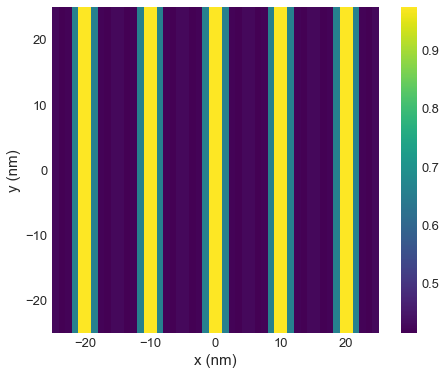

In [1]:
>>> import discretisedfield as df
>>> import micromagneticmodel as mm
>>> import numpy as np
>>> import mag2exp
>>> mesh = df.Mesh(p1=(-25e-9, -25e-9, -25e-9),
...                p2=(25e-9, 25e-9, 25e-9),
...                cell=(1e-9, 1e-9, 1e-9))
>>> def v_fun(point):
...     x, y, z = point
...     q = 10e-9
...     return (0,
...             np.sin(2 * np.pi * x / q),
...             np.cos(2 * np.pi * x / q))
>>> field = df.Field(mesh, dim=3, value=v_fun, norm=1e5)
>>> E_i = [1, 1j]
>>> intensity = mag2exp.moke.intensity(field, 0, 2, 1, 600e-9, E_i,
...                                    mode='reflection')
>>> intensity.mpl()

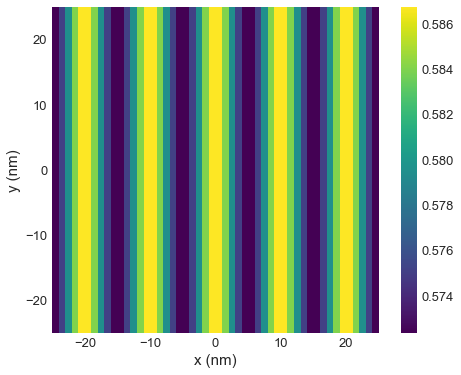

In [3]:
>>> intensity2 = mag2exp.moke.intensity(field, 0, 2, 1, 600e-9, E_i,
...                                     mode='reflection', fwhm=(10e-9, 10e-9))
>>> intensity2.mpl()

In [36]:
angle.array.all() != 0

True

In [2]:
E_f = mag2exp.moke.e_field(field, 0, 2, 1, 600e-9, E_i, mode='reflection')

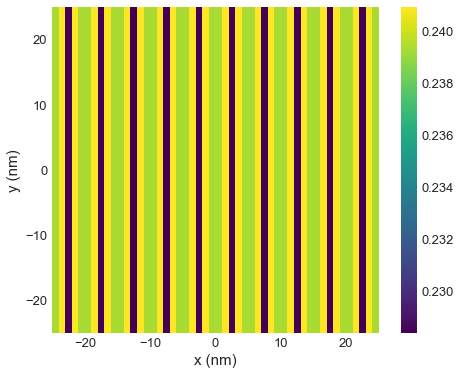

In [7]:
E_f.s.mpl.scalar()

In [4]:
E_f.p

Field(mesh=Mesh(region=Region(p1=(-2.5e-08, -2.5e-08, -5e-10), p2=(2.5e-08, 2.5e-08, 5e-10)), n=(50, 50, 1), bc='', subregions={}, attributes={'unit': 'm', 'fourierspace': False, 'isplane': True, 'planeaxis': 2, 'point': 0.0, 'axis1': 0, 'axis2': 1}), dim=1)

In [ ]:
import numpy as np

\begin{equation}
    A_{j} =
    \begin{pmatrix}
    1 & 0 & 1 & 0 \\
    \frac{iQ\alpha^2_{yi}}{2} \left(m_y \frac{1+\alpha^2_{zi}}{\alpha_{yi}\alpha_{zi}} - m_z\right) & \alpha_{zi} &
    -\frac{iQ\alpha^2_{yi}}{2} \left(m_y \frac{1+\alpha^2_{zi}}{\alpha_{yi}\alpha_{zi}} + m_z\right) & -\alpha_{zi} \\
    -\frac{in_jQ}{2} \left(m_y \alpha_{yi} + m_z \alpha_{zi} \right) & -n_j &
    -\frac{in_jQ}{2} \left(m_y \alpha_{yi} - m_z \alpha_{zi} \right) & -n_j \\
    n_j\alpha_{zj} & -\frac{in_jQ}{2} \left(m_y \frac{\alpha_{yi}}{\alpha_{zi}} - m_z \right) & -n_j \alpha_{zj} &
    \frac{in_jQ}{2} \left(m_y \frac{\alpha_{yi}}{\alpha_{zi}} + m_z \right)
    \end{pmatrix}
\end{equation}
$\alpha_{yi}=\sin\theta_j, \alpha_{zi}=\cos\theta_j$

In [ ]:
def calculate_A(theta_j, nj, Q, mx_arr, my_arr, mz_arr):
    a_yj = np.sin(theta_j)
    a_zj = np.cos(theta_j)
    
    s = np.shape(mx_arr)
    mx_arr = mx_arr.flatten()
    my_arr = my_arr.flatten()
    mz_arr = mz_arr.flatten()
    
    A = []

    for (mx, my, mz) in zip(mx_arr, my_arr, mz_arr):
    
        A.append([[1, 0, 1, 0],
                  [(1j*Q)*(a_yj*my*(1+a_zj**2)/a_zj - mz*a_yj**2)/2, a_zj,
                    -(1j*Q)/2 * (a_yj*my*(1+a_zj**2)/a_zj + mz*a_yj**2), -a_zj],
                  [-(1j*Q*nj)/2 * (my*a_yj + mz*a_zj), -nj, -(1j*Q*nj)/2 * (my*a_yj - mz*a_zj), -nj],
                  [nj*a_zj, -(1j*Q*nj)/2 * (my*a_yj/a_zj - mz), -nj*a_zj, (1j*Q*nj)/2 * (my*a_yj/a_zj + mz)]])
    return np.reshape(A, (*s,4,4))

In [ ]:
A = calculate_A(0, 1, 1, np.array(1), np.array(1), np.array(1))
normal_incidence_A = np.array([[1,0,1,0],[0,1,0,-1],[-0.5j, -1, 0.5j, -1], [1, 0.5j, -1, 0.5j]])
np.allclose(A, normal_incidence_A)

\begin{equation}
    D_{j} =
    \begin{pmatrix}
    U\cos\delta^i & U\sin\delta^i & 0 & 0 \\
    -U\sin\delta^i & U\cos\delta^i & 0 & 0 \\
    0 & 0 & U^{-1}\cos\delta^r & U^{-1}\sin\delta^r \\
    0 & 0 & -U^{-1}\sin\delta^r & U^{-1}\cos\delta^r
    \end{pmatrix}
\end{equation}

\begin{align}
    U &= \exp\left(\frac{-i2\pi n_j \alpha_{zj} d_j}{\lambda} \right)\\ 
    \delta^i &= -\frac{\pi n_j Q d_j g^i}{\lambda \alpha_{zj}} \\
    \delta^r &= -\frac{\pi n_j Q d_j g^r}{\lambda \alpha_{zj}} \\
    g^i &= m_z \alpha_{zj} + m_y \alpha_{yj} \\
    g^r &= m_z \alpha_{zj} - m_y \alpha_{yj}
\end{align}

In [ ]:
def calculate_D(theta_j, nj, Q, dj, wavelength, mx_arr, my_arr, mz_arr):
    a_yj = np.sin(theta_j)
    a_zj = np.cos(theta_j)
    s = np.shape(mx_arr)
    mx_arr = mx_arr.flatten()
    my_arr = my_arr.flatten()
    mz_arr = mz_arr.flatten()

    D = []
    for (mx, my, mz) in zip(mx_arr, my_arr, mz_arr):
        gi = mz*a_zj + my*a_yj
        gr = mz*a_zj - my*a_yj
        di = -np.pi*nj*Q*dj*gi/(wavelength*a_zj)
        dr = -np.pi*nj*Q*dj*gr/(wavelength*a_zj)
        U = np.exp(-2j*np.pi*nj*a_zj*dj/wavelength)

        D.append([[U*np.cos(di), U*np.sin(di), 0, 0],
            [-U*np.sin(di), U*np.cos(di), 0, 0],
            [0, 0, np.cos(dr)/U, np.sin(dr)/U],
            [0, 0, -np.sin(dr)/U, np.cos(dr)]])
        
    return np.reshape(D, (*s,4,4))

In [ ]:
D = calculate_D(1e-10, 1, 1, 1, 1, np.array(1), np.array(1), np.array(1))
normal_incidence_D = np.array([[-np.exp(-2j*np.pi),0,0,0],[0,-np.exp(-2j*np.pi),0,0],[0, 0, -1/np.exp(-2j*np.pi), 0], [0, 0, 0, -1/np.exp(-2j*np.pi)]])
np.allclose(D, normal_incidence_D)

\begin{equation}
    n_0 \sin\theta_0 = n_1 \sin\theta_1
\end{equation}

In [ ]:
def theta1(theta0, n0, n1):
    return np.arcsin((n0*np.sin(theta0))/n1)

e.g.
\begin{equation}
    M = A^{-1}_0  A_1 D_1 A^{-1}_1 A_2
\end{equation}

In [ ]:
theta = 1.04

A = calculate_A(theta, 1, 0, np.array(1), np.array(1), np.array(1))
M = np.linalg.inv(A)
theta = theta1(theta, 1, 2)
A = calculate_A(theta, 2, 1, np.array(1), np.array(1), np.array(1))
M = np.matmul(M, A)
D = calculate_D(theta, 2, 1, 1, 10, np.array(1), np.array(1), np.array(1))
M = np.matmul(M, D)
A = calculate_A(theta, 2, 1, np.array(1), np.array(1), np.array(1))
M = np.matmul(M, np.linalg.inv(A))
theta = theta1(theta, 2, 1)
A = calculate_A(theta, 1, 0, np.array(1), np.array(1), np.array(1))
M = np.matmul(M, A)

\begin{equation}
    M = \begin{pmatrix} G & H \\ I & J \end{pmatrix}
\end{equation}

\begin{equation}
    \begin{pmatrix} r_{ss} & r_{sp} \\ r_{ps} & r_{pp} \end{pmatrix}
    = I G^{-1}
\end{equation}

In [ ]:
G = M[0:2, 0:2]
I = M[2:4, 0:2]
G_inv = np.linalg.inv(G)
r = np.matmul(I, G_inv)

\begin{equation}
    \begin{pmatrix} E^r_s \\ E^r_p \end{pmatrix} = 
    \begin{pmatrix} r_{ss} & r_{sp} \\ r_{ps} & r_{pp} \end{pmatrix}
    \begin{pmatrix} E^i_s \\ E^i_p \end{pmatrix}
\end{equation}

In [ ]:
E_i = [0, 1]
E_f = np.matmul(r, E_i)

In [ ]:
I = abs(E_f[0])**2 + abs(E_f[1])**2
I

Full Grid

In [ ]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(1)
region = df.Region(p1=(-150e-9, -150e-9, 0), p2=(150e-9, 150e-9, 5e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name='Box2')

system.energy = (mm.Exchange(A=1.6e-11)
                 + mm.DMI(D=4e-3, crystalclass='Cnv') 
                 + mm.UniaxialAnisotropy(K=0.51e6, u=(0, 0, 1)) 
                 + mm.Demag()
                 + mm.Zeeman(H=(0, 0, 2e5)))

Ms = 1.1e6

def m_fun(pos):
    return 2 * np.random.rand(3) - 1

# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, dim=3, value=m_fun, norm=Ms)
system.m.plane('z').mpl()

In [ ]:
# NBVAL_IGNORE_OUTPUT
# minimize the energy
md = oc.MinDriver()
md.drive(system)

In [ ]:
# Plot relaxed configuration: vectors in z-plane
system.m.plane('z').mpl()

In [ ]:
system.m.plane('x').mpl()

In [ ]:
import mag2exp

In [ ]:
E_i = [1, 0]
E_r = mag2exp.moke.e_field(system.m, 0, 2, 1, 600e-9, E_i, mode='reflection')

In [ ]:
E_i = [1, 1j]/np.sqrt(2)
intensity_t = mag2exp.moke.intensity(system.m, 0, 2, 1, 600e-9, E_i, mode='t')

In [ ]:
intensity_t.mpl()

In [ ]:
E_i = [1, 1j]/np.sqrt(2)
intensity_r = mag2exp.moke.intensity(system.m, 0, 2, 1, 600e-9, E_i, mode='r')
intensity_r.mpl()

In [ ]:
(intensity_r + intensity_t).mpl()

In [ ]:
angle = mag2exp.moke.kerr_angle(system.m, 0, 2, 1, 600e-9, mode='reflection')

In [ ]:
angle.p.imag.mpl.scalar()

In [ ]:
intensity = mag2exp.moke.moke_intensity(system.m, 0, 2, 1, 600e-9, [1, 1j])

In [ ]:
intensity.mpl.scalar()

In [ ]:
def calculate_M(field, theta, n, Q, wavelength):
    field_arr = field.orientation.array
    mx_arr = field_arr[..., 0]
    my_arr = field_arr[..., 1]
    mz_arr = field_arr[..., 2]
    
    # Free space
    A = calculate_A(theta, 1, 0, mx_arr[...,0], my_arr[...,0], mz_arr[...,0])
    M = np.linalg.inv(A)

    # Sample
    theta = theta1(theta, 1, n)
    for i in reversed(range(mx_arr.shape[2])):  # Think about direction of loop 
        A = calculate_A(theta, n, Q, mx_arr[...,i], my_arr[...,i], mz_arr[...,i])
        M = np.matmul(M, A)
        D = calculate_D(theta, n, Q, field.mesh.dx, wavelength, mx_arr[...,i], my_arr[...,i], mz_arr[...,i])
        M = np.matmul(M, D)
        A = calculate_A(theta, n, Q, mx_arr[...,i], my_arr[...,i], mz_arr[...,i])
        M = np.matmul(M, np.linalg.inv(A))
    
    # Free space
    theta = theta1(theta, n, 1)
    A = calculate_A(theta, 1, 0, mx_arr[...,0], my_arr[...,0], mz_arr[...,0])
    M = np.matmul(M, A)
    return M

def calculate_r(M):
    G = M[:, :, 0:2, 0:2]
    I = M[:, :, 2:4, 0:2]
    G_inv = np.linalg.inv(G)
    return np.matmul(I,G_inv)

def calculate_t(M):
    G = M[:, :, 0:2, 0:2]
    G_inv = np.linalg.inv(G)
    return G_inv

In [ ]:
M = calculate_M(system.m, 5*np.pi/180, 0.12+3.29j, 0.376+0.0066j, 600e-9)

In [ ]:
r = calculate_r(M)

In [ ]:
r1 = r[0,0]

In [ ]:
a = r1[0,0]
b = r1[0,1]
c = r1[1,0]
d = r1[1,1]

In [ ]:
b/(np.sqrt(a)*np.sqrt(d))

In [ ]:
c/(np.sqrt(a)*np.sqrt(d))

In [ ]:
E_i = np.array([1, 1j])  #/np.sqrt(2)
E_r = np.matmul(r, E_i)

In [ ]:
I = np.abs(E_r[...,0])**2 + np.abs(E_r[...,1])**2
Int = df.Field(mesh=system.m.integral('z').mesh, dim=1, value=I[..., np.newaxis, np.newaxis])
Int.mpl.scalar(interpolation='spline16')

In [ ]:
I = np.abs(E_r[...,0])**2 + np.abs(E_r[...,1])**2
Int = df.Field(mesh=system.m.integral('z').mesh, dim=1, value=I[..., np.newaxis, np.newaxis])
Int.mpl.scalar(interpolation='spline16')

In [ ]:
Kerr_angle = r[:,:,1,0]/r[:,:,0,0]

In [ ]:
ang = df.Field(mesh=system.m.integral('z').mesh, dim=1, value=Kerr_angle[..., np.newaxis, np.newaxis])
ang.real.mpl.scalar(interpolation='spline16')
ang.imag.mpl.scalar(interpolation='spline16')

In [ ]:
t = calculate_t(M)

In [ ]:
E_i = [1, 1j]
E_t = np.matmul(t, E_i)

In [ ]:
I = np.abs(E_t[...,0])**2 + np.abs(E_t[...,1])**2
Int = df.Field(mesh=system.m.integral('z').mesh, dim=1, value=I[..., np.newaxis, np.newaxis])
Int.mpl.scalar(interpolation='spline16')

In [ ]:
system.m.mesh.

In [ ]:
slider_min = system.m.mesh.index2point((0, 0, 0))[2]
slider_max = system.m.mesh.index2point(np.subtract(system.m.mesh.n, 1))[2]
slider_step = system.m.mesh.cell[2]
values = np.arange(slider_min, slider_max+1e-20, slider_step)

In [ ]:
values.shape

\begin{equation}
    \epsilon = n^2_0 
    \begin{bmatrix}
    1 & -iQm_z & iQm_y \\
    iQm_z & 1 & -iQm_x \\
    -iQm_y & iQm_x & 1 
    \end{bmatrix}
\end{equation}

In [ ]:
n_0 = 2
Q = 0
mx = my = mz = 1
e = n_0**2 * np.array([[1, -1j*Q*mx, 1j*Q*my],[1j*Q*mz, 1, -1j*Q*mx],[-1j*Q*my, 1j*Q*mx, 1]])

In [ ]:
theta = np.pi/4
k = np.array([0, np.sin(theta), np.cos(theta)])

In [ ]:
np.linalg.norm(np.dot(e, k))

In [ ]:
np.sqrt(np.dot(e, k))

In [ ]:
M = mag2exp.moke._calculate_M(system.m, 0, 3, 1, 600e-9)
m = mag2exp.moke._M_to_r(M)
k_s_r = -np.real(m[..., 1, 0]/m[..., 0, 0])
k_p_r = np.real(m[..., 0, 1]/m[..., 1, 1])
k_s_i = -np.imag(m[..., 1, 0]/m[..., 0, 0]) * k_s_r
k_p_i = np.imag(m[..., 0, 1]/m[..., 1, 1]) / k_p_r

k_s = k_s_r + 1j * k_s_i
k_p = k_p_r + 1j * k_p_i

In [ ]:
k_s2 = -m[..., 1, 0]/m[..., 0, 0]
k_s2[0,0]

In [ ]:
k_s[0,0]

In [ ]:
k_p2 = -m[..., 0, 1]/m[..., 1, 1]
k_p2[0,0]

In [ ]:
k_p[0,0]

In [ ]:
k_a = np.stack([k_s, k_p], axis=-1)

In [ ]:
k_a[:,:,np.newaxis,:].shape

In [ ]:
(*m.shape[0:2], 1)

In [ ]:
E_f.reshape((60,60,1,2))

In [ ]:
system.m

In [ ]:
E_f = mag2exp.moke.e_field(system.m, 0, 2, 1, 600e-9, [1, 1j])

In [ ]:
E_f.components